# Variance explained by metadata covariates (HLCA Figure 4a, Extended Data Figure 9)

In this notebook we'll determine how much of the variance in the integrated HLCA embedding is explained by each of the metadata covariates (e.g. smoking status, single-cell platform, tissue sampling method, etc.).

### Import modules, set paths, load files:

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.gridspec import GridSpec
import seaborn as sns
import sys
import os
import copy
from adjustText import adjust_text

sys.path.append("../../scripts/")
import utils
import analysis

from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from scipy.stats import entropy


For pretty code formatting (not needed to run code):

In [2]:
%load_ext lab_black

In [3]:
%load_ext autoreload
%autoreload 2

Set paths:

In [4]:
path_HLCA = "../../data/HLCA_core_h5ads/HLCA_v2.h5ad"
dir_results = "../../results/variance_explained_by_covariates/"
dir_figures = "../../results/figures/"

Load files:

In [5]:
adata = sc.read(path_HLCA)

Create empty dictionary to store figures in:

In [6]:
FIGURES = dict()

### Simplify metadata where necessary:

reduce cellranger version to a single digit (e.g. 3 or 4):

In [7]:
cr_vers = sorted(set(adata.obs.cell_ranger_version))

In [8]:
cr_to_short_cr = dict()
for v in cr_vers:
    if v == "nan":
        cr_to_short_cr[v] = np.nan
    else:
        cr_to_short_cr[v] = v[0]

In [9]:
adata.obs["cell_ranger_version_short"] = pd.Categorical(
    adata.obs.cell_ranger_version.map(cr_to_short_cr)
)

Check resulting simplified versions:

In [10]:
set(adata.obs.cell_ranger_version_short)

{'1', '2', '3', '4', nan}

Reduce sequencing platform to main version (e.g. set Illumina NovaSeq 6000 S1, S2, etc. all to Illumina NovaSeq 6000):

In [11]:
scp_to_scp_short = dict()
for scp in sorted(set(adata.obs.sequencing_platform)):
    if "6000" in scp:
        if "4000" in scp:
            scp_to_scp_short[scp] = np.nan
        else:
            scp_to_scp_short[scp] = "Illumina NovaSeq 6000"
    elif "4000" in scp:
        scp_to_scp_short[scp] = "Illumina HiSeq 4000"
    elif scp == "nan":
        scp_to_scp_short[scp] = np.nan
    elif scp == "Illumina NextSeq 500":
        scp_to_scp_short[scp] = "Illumina NextSeq 500"
    else:
        print(f"WARNING: no translation for {scp}!")

Show mapping that we'll use:

In [12]:
scp_to_scp_short

{'Illumina HiSeq 4000': 'Illumina HiSeq 4000',
 'Illumina NextSeq 500': 'Illumina NextSeq 500',
 'Illumina NovaSeq 6000': 'Illumina NovaSeq 6000',
 'Illumina NovaSeq 6000 S1': 'Illumina NovaSeq 6000',
 'Illumina NovaSeq 6000 S2': 'Illumina NovaSeq 6000',
 'Illumina NovaSeq 6000 S4': 'Illumina NovaSeq 6000',
 'Illumina NovaSeq 6000 SP': 'Illumina NovaSeq 6000',
 'Illumina NovaSeq 6000; Illumina HiSeq 4000': nan,
 'nan': nan}

Now map, generate a new adata.obs column:

In [13]:
adata.obs["sequencing_platform_short"] = pd.Categorical(
    adata.obs.sequencing_platform.map(scp_to_scp_short)
)

Check set of values in simplified column:

In [14]:
set(adata.obs.sequencing_platform_short)

{'Illumina HiSeq 4000', 'Illumina NextSeq 500', 'Illumina NovaSeq 6000', nan}

For the modeling of anatomical region/ccf score, we want to model nose separately from the airways/lungs, as changes from nose to the airways might often be independent of continuous changes along the airways into the lungs. We will therefore create a boolean variable "nose", set to 1 for all nose samples and 0 for all other samples, and set the anatomical region ccf score for nose to the lowest non-nose value (trachea; 0.36), so that nose-specific variation will be exclusively captured by the nosevariable.

In [15]:
adata.obs["nose"] = (adata.obs.anatomical_region_level_1 == "nose").astype(int)
adata.obs.loc[
    adata.obs.anatomical_region_level_1 == "nose", "anatomical_region_ccf_score"
] = 0.36

encode smoking as numerical vector (this is not used below atm, CONSIDER CHANGING FOR REVISIONS):

In [16]:
smoking_to_cont = {"active": 1, "former": 0.5, "never": 0}

In [17]:
adata.obs["smoking_status_num"] = adata.obs.smoking_status.map(smoking_to_cont).astype(
    float
)

Set all versions of nan to np.nan, i.e. "nan", np.nan, None, "None" etc. 

In [18]:
none_entries = adata.obs.applymap(utils.check_if_nan)
adata.obs = adata.obs.mask(none_entries)

### Perform regression:

Select covariates to include:

In [19]:
adata

AnnData object with n_obs × n_vars = 584944 × 28527
    obs: 'sample', 'original_celltype_ann', 'study_long', 'study', 'last_author_PI', 'subject_ID', 'subject_ID_as_published', 'pre_or_postnatal', 'age_in_years', 'age_range', 'sex', 'smoking_status', 'smoking_history', 'BMI', 'known_lung_disease', 'condition', 'subject_type', 'cause_of_death', 'sample_type', 'anatomical_region_coarse', 'anatomical_region_detailed', 'tissue_dissociation_protocol', 'cells_or_nuclei', 'single_cell_platform', "3'_or_5'", 'enrichment', 'sequencing_platform', 'reference_genome_coarse', 'ensembl_release_reference_genome', 'cell_ranger_version', 'disease_status', 'fresh_or_frozen', 'cultured', 'cell_viability_%', 'comments', 'Processing_site', 'dataset', 'anatomical_region_level_1', 'anatomical_region_level_2', 'anatomical_region_level_3', 'anatomical_region_highest_res', 'age', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'ann_highest_res', 'ann_new', 'n_genes', 'total_counts', 

In [20]:
covariates = [
    "dataset",
    "tissue_dissociation_protocol",
    "log10_total_counts",
    "mito_frac",
    "3'_or_5'",
    "BMI",
    "cell_ranger_version_short",
    "cell_viability_%",
    "ancestry",
    "fresh_or_frozen",
    "sample_type",
    "sequencing_platform_short",
    "sex",
    "single_cell_platform",
    "smoking_status_num",
    "subject_type",
    "subject_ID",
    "anatomical_region_ccf_score",
    "nose",
    "age",
    "manual_ann",
]

sanity check:

In [21]:
for cov in covariates:
    if type(adata.obs[cov].values) == pd.Categorical:
        print(cov.upper())
        print(set(adata.obs[cov]))
        print("\n")
    else:
        print(cov.upper(), "not a categorical.\n")

DATASET
{'Misharin_2021', 'Barbry_Leroy_2020', 'Lafyatis_Rojas_2019_10Xv1', 'Jain_Misharin_2021_10Xv2', 'Teichmann_Meyer_2019', 'Krasnow_2020', 'Jain_Misharin_2021_10Xv1', 'Seibold_2020_10Xv3', 'Seibold_2020_10Xv2', 'Misharin_Budinger_2018', 'Banovich_Kropski_2020', 'Nawijn_2021', 'Meyer_2019', 'Lafyatis_Rojas_2019_10Xv2'}


TISSUE_DISSOCIATION_PROTOCOL
{'Cold protease 1h', 'Dispase + collagenase', 'Collagenase A + DNAse', 'Collagenase + Elastase + DNAse', 'Collagenase D + DNAse', 'Cold protease overnight'}


LOG10_TOTAL_COUNTS not a categorical.

MITO_FRAC not a categorical.

3'_OR_5'
{"5'", "3'"}


BMI not a categorical.

CELL_RANGER_VERSION_SHORT
{nan, '1', '2', '3', '4'}


CELL_VIABILITY_% not a categorical.

ANCESTRY
{nan, 'european', 'american', 'asian', 'mixed', 'pacific islander', 'african'}


FRESH_OR_FROZEN
{'frozen', 'fresh'}


SAMPLE_TYPE
{'biopsy', 'surgical_resection', 'scraping', 'brush', 'donor_lung'}


SEQUENCING_PLATFORM_SHORT
{'Illumina NextSeq 500', nan, 'Illumina N

We will now perform a linear regression for every latent component with every covariate selected above. Although in the paper we only show the results based on the components from the scANVI-integrated HLCA, we can do the same for the non-integrated PCA-based principal components.  
Where the covariate is continuous or binary (two categories, converted to a single vector of 0s and 1s), we can do a simple linear regression explaining our y variable (component) based on our x variable (metadata category). Where the covariate is a categorical with more than two categories, we'll have to create "dummies", generating a 1-hot encoded binary variable for (n_categories - 1) categories, and perform a linear regression explaining our y variable based on the resulting multi-variate matrix.

Specify whether to do the analysis for the "integrated" and/or "unintegrated" atlas with the following list: 

In [22]:
int_types = ["integrated"]  # list needs to include "integrated" and/or "unintegrated"

Set number of principal components for the "unintegrated" PCA-based analysis. We set it to 30 here, as we also use 30 components for scANVI. Note that currently, we re-do the PCA for every cell type. One can argue that that is not the right comparison.

In [23]:
if "unintegrated" in int_types:
    n_pcs = 30

Minimum number of total cells of a cell type to be considered for analysis, minimum number of cells of a cell type for a sample to be included in the analysis, and minimum number of samples passing that criterium for a cell type to be analysed:

In [24]:
min_n_cells_total = 50  # in total
min_n_cells = 10  # per sample
min_n_samples = 2

verbose or not:

In [25]:
verbose = True

check if needed output dirs exists, if not, create them:

In [26]:
outdir_1 = os.path.join(dir_results, f"variance_explained_fractions/")
if not os.path.exists(outdir_1):
    print("Creating directory:", outdir_1)
    os.makedirs(outdir_1)
outdir_2 = os.path.join(dir_results, f"samples_included/")
if not os.path.exists(outdir_2):
    print("Creating directory:", outdir_2)
    os.mkdir(outdir_2)

We will now loop through "integrations" (unintegrated PC-based and/or integrated scANVI-component based), and through cell types, and perform the regressions described above for every covariate-cell type pair. We'll store the results to files. The results are, for every cell type:
1) a list of fraction-of-variance-explained values for each covariate (ranging from 0 to 1)<br>
2) a table specifying for every covariate, for every subject, whether or not it was included in the regression. As subjects are often not annotated for all covariates, they might be excluded for one regression but not for the next. Subjects will also be excluded if they do not contain more than min_n_cells (set above) of the cell type under consideration.

In [27]:
if not False:
    print("yes")

yes


In [28]:
# Initiate a dictionary, in which we will store which samples were included per
# single regression
samples_included = dict()
cts_to_skip = list()  # we will fill this with cts that have too few samples
# these samples should be skipped in the rest of the analysis.
# Loop through specified integration types:
for int_type in int_types:
    samples_included[int_type] = dict()
    # loop through all annotations (= cell types), and also include the entire
    # atlas as a "cell type":
    for subset in sorted(adata.obs.manual_ann_grouped.unique()) + ["whole_atlas"]:
        # remove space from cell type name, for file storing etc.
        subset_no_space = subset.replace(" ", "_")
        # initiate a dataframe, in which we will store for every covariate
        # which samples we include in the regression (we will exclude samples
        # that have no value available for the covariate under consideration
        # (e.g. BMI not recorded), as well as samples that have fewer than 10
        # cells of the cell type under consideration)
        samples_included[int_type][subset] = pd.DataFrame(
            index=adata.obs["sample"].unique(), columns=covariates
        )
        # if file doesn't exist yet (built in this check for if loop breaks halfway,
        # feel free to take it out):
        if not os.path.isfile(
            os.path.join(
                dir_results,
                f"variance_explained_fractions/variance_explained_fractions_{subset_no_space}_{int_type}.csv",
            )
        ):
            print(f"Working on {int_type}, {subset}...")
            # select the correct cells:
            if subset == "whole_atlas":
                subadata = adata.copy()
                verbose = True
            elif subset not in adata.obs.manual_ann_grouped.unique():
                raise ValueError(
                    "subset should be set either to 'Whole atlas' or to a category in your manual_ann grouped obs variable!"
                )
            else:
                subadata = adata[adata.obs.manual_ann_grouped == subset, :].copy()
                verbose = False
            if subadata.n_obs < min_n_cells_total:
                print(f"{subset} has fewer than {min_n_cells_total} cells! Skipping.")
                continue
            # select the right embedding:
            if int_type == "unintegrated":
                emb_name = "X_pca"
                sc.tl.pca(subadata, n_comps=n_pcs, use_highly_variable=True)
            elif int_type == "integrated":
                emb_name = "X_scanvi_emb"
            else:
                raise ValueError(
                    "emb_name should be set either to 'integrated' or 'unintegrated'"
                )
            # store the number of components in our embedding of choice
            n_comps = subadata.obsm[emb_name].shape[1]
            # initiate a dataframe in which we'll store the variance explained
            # by each covariate, plus the total variance ("overall") observed
            var_explained = pd.DataFrame(
                index=range(n_comps), columns=covariates + ["overall"]
            )
            # initiate a dataframe in which we will store the data
            # for our linear regression (i.e. the PC/latent components, + covariates).
            # Rows are cells, but we will collapse this to samples below
            comp_sample_df = pd.DataFrame(index=subadata.obs.index)
            comp_sample_df["sample"] = subadata.obs["sample"]
            # prepare aggregation dictionary for collapsing into sample-wise
            # observations
            agg_dict = {"sample": "count"}  # this will be number of cells
            for comp in range(n_comps):
                # store component scores per cell
                comp_sample_df[f"comp{comp}"] = subadata.obsm[emb_name][:, comp]
                # we will aggregate these later by taking the mean per sample
                agg_dict[f"comp{comp}"] = "mean"
            for cov in covariates:
                if cov in ["log10_total_counts", "mito_frac"]:
                    # store values
                    comp_sample_df[cov] = subadata.obs[cov]
                    # we will aggregate by taking the mean
                    agg_dict[cov] = "mean"
                else:
                    # for all other covariates: these are sample-level
                    # covariates, so we will take the "first" overservation
                    # in the sample (which should be the only)
                    comp_sample_df[cov] = subadata.obs[cov]
                    agg_dict[cov] = "first"
            # now collapse into sample-level observations
            sample_df = (
                comp_sample_df.groupby("sample")
                .agg(agg_dict)
                .rename(columns={"sample": "n_cells"})
            )
            # filter out samples with fewer than min_n_cells cells of the cell type
            sample_df = sample_df.loc[
                sample_df.n_cells >= min_n_cells,
            ].copy()
            # check number of samples left.
            # If fewer than min_n_samples remain, we will skip the cell type
            if sample_df.shape[0] < min_n_samples:
                print(
                    f"Only {sample_df.shape[0]} samples available for {subset}. Skipping."
                )
                cts_to_skip.append(subset)
                continue
            # Otherwise, move on to the linear regression:
            # do a linear regression on each component, with the component scores
            # as response variable...
            for comp in range(n_comps):
                # store the component values (for all samples i.e. unfiltered)
                y_true_unfiltered = sample_df.loc[:, f"comp{comp}"].values
                # and store variance of y_true as "overall" variance
                var_explained.loc[f"comp{comp}", "overall"] = np.var(y_true_unfiltered)
                # and the covariate as fixed variable
                for cov in covariates:
                    # store covariate observations under x
                    x = sample_df[cov].values.copy()
                    # store samples to which they match
                    x_samples = sample_df.index
                    # check which of these samples have no observation (e.g.
                    # because BMI was unknown, or age, etc.)
                    # (the function used below checks for different kinds of
                    # nas, e.g. np.nan, "nan", None, "None" etc.)
                    x_nans = np.vectorize(utils.check_if_nan)(x)
                    # now keep only xs that have real observations
                    x = x[~x_nans]
                    # if only one or no observations are left, skip this covariate
                    if len(x) < 2:
                        continue
                    # filter samples according to x filtering
                    x_samples = x_samples[~x_nans]
                    # and store which samples were included in our samples_included
                    # dictionary, for later reference (this is our "n")
                    samples_included[int_type][subset][cov] = samples_included[
                        int_type
                    ][subset].index.isin(x_samples.tolist())
                    # filter y_true according to x's filtering
                    y_true = y_true_unfiltered[~x_nans].reshape(-1, 1)
                    # prepare x for linear regression:
                    # if it is a float (e.g. BMI, age), all we need to do is reshape:
                    if x.dtype in ["float32", "float", "float64"]:
                        x = x.reshape(-1, 1)
                        # print that we are treating as numerical (only for first comp,
                        # so that we don't print the same thing many times)
                        if comp == 0 and verbose:
                            print(f"treating {cov} as continuous variable")
                    # otherwise we are dealing with a categorical...
                    else:
                        # if it has only one category, there is 0 variance and
                        # we cannot perform linear regression. In that case,
                        # move on to the next covariate.
                        if len(set(x)) == 1:
                            var_explained.loc[comp, cov] = np.nan
                            continue
                        # Otherwise, convert x to dummied variable:
                        # print that we are converting to dummy
                        # (only do it for the first comp, otherwise we print the same thing
                        # many times)
                        if comp == 0 and verbose:
                            print(f"converting {cov} to dummy variable")
                        # drop_first means we ensure that are x is full rank,
                        # and we only encode all-1 categories
                        x = pd.get_dummies(x, drop_first=True)
                    # now perform linear regression
                    lrf = LinearRegression(fit_intercept=True).fit(
                        x,
                        y_true,
                    )
                    # predict y based on the fit linear model
                    y_pred = lrf.predict(x)
                    # and store the variance of the predicted y, this is the
                    # "variance explained" by the covariate, for this component
                    var_explained.loc[comp, cov] = np.var(y_pred)
            # for each covariate, sum up how much variance it explains across
            # the components (i.e. PCs or scANVI latent components)
            # Sort covariates from explaining most to explaining least
            total_variance_explained = np.sum(var_explained, axis=0).sort_values(
                ascending=False
            )
            # divide this by the total variance that was observed in the
            # components, to get fraction of variance explained
            total_variance_explained_fractions = (
                total_variance_explained / total_variance_explained["overall"]
            )
            # write to files:
            # 1) variance explained fractions, for this integration type and cell type
            total_variance_explained_fractions.to_csv(
                os.path.join(
                    dir_results,
                    f"variance_explained_fractions/variance_explained_fractions_{subset_no_space}_{int_type}.csv",
                )
            )
            # 2) samples included, for this cell type
            samples_included[int_type][subset].to_csv(
                os.path.join(
                    dir_results,
                    f"samples_included/samples_included_{subset_no_space}.csv",
                )
            )

Working on integrated, Hematopoietic stem cells...
Only 1 samples available for Hematopoietic stem cells. Skipping.


## Plot variance explained results (Figure 4a):

Choose the integration type for which to plot the results:

In [29]:
int_type = "integrated" # we used integrated in the paper, not unintegrated

Organize results in a dataframe (with fractions of variance explained) and a dictionary (one df with samples included per ct):

In [30]:
subsets = ["whole_atlas"] + sorted(adata.obs.manual_ann_grouped.unique())
# import variance explained fractions for the Whole atlas, to get indices
# and columns for dataframes
vef_df = pd.read_csv(
    os.path.join(
        dir_results,
        f"variance_explained_fractions/variance_explained_fractions_whole_atlas_{int_type}.csv",
    ),
    index_col=0,
).rename(columns={"0": "uncorrected"})
# inititate empty dataframes for variance explained fractions
vars_expl = pd.DataFrame(
    index=[subs for subs in subsets if subs not in cts_to_skip], columns=vef_df.index
)
# initiate an empty dictionary to store samples included for each cell type - cov
# pair
samples_included = dict()
# loop through cell types + Whole atlas
for subset in subsets:
    if subset not in cts_to_skip:
        # replace spaces in cell type name with "_" for file writing etc.
        subset_no_space = subset.replace(" ", "_")
        # import variance explained fractions:
        vef_df = pd.read_csv(
            os.path.join(
                dir_results,
                f"variance_explained_fractions/variance_explained_fractions_{subset_no_space}_{int_type}.csv",
            ),
            index_col=0,
        ).rename(columns={"0": "uncorrected"})
        # store values in our overview dataframes
        vars_expl.loc[subset, vef_df.index] = vef_df.values.reshape(1, -1)
        # store which samples were included for each covariate based on matching file
        samples_included[subset] = pd.read_csv(
            os.path.join(
                dir_results, f"samples_included/samples_included_{subset_no_space}.csv"
            ),
            index_col=0,
        )
# rename "whole_atlas" to "Whole atlas" index, for prettier plotting
vars_expl.rename(index={"whole_atlas": "Whole atlas"}, inplace=True)

Check which categorical covariates only have a single category in which cell types. We will mask those parts of the heatmap below, since no linear regression is possible there.

First, separate continuous from categorical covariates:

In [31]:
# collect categorical covariates...
cat_covs = [
    cat
    for cat in covariates
    if adata.obs[cat].values.dtype
    not in [
        "float32",
        "float",
        "float64",
    ]
]
# and continuous/numerical covariates
cont_covs = [
    cat
    for cat in covariates
    if adata.obs[cat].values.dtype
    in [
        "float32",
        "float",
        "float64",
    ]
]

Check:

In [32]:
print(cat_covs)

['dataset', 'tissue_dissociation_protocol', "3'_or_5'", 'cell_ranger_version_short', 'ancestry', 'fresh_or_frozen', 'sample_type', 'sequencing_platform_short', 'sex', 'single_cell_platform', 'subject_type', 'subject_ID', 'nose', 'manual_ann']


In [33]:
print(cont_covs)

['log10_total_counts', 'mito_frac', 'BMI', 'cell_viability_%', 'smoking_status_num', 'anatomical_region_ccf_score', 'age']


Now determine number of categories per covariate cell type pair:

In [34]:
# aggregate values by sample
agg_dict = {cov: "first" for cov in cat_covs}  # use "first" for categorical
agg_dict.update({cov: "mean" for cov in cont_covs})  # and "mean" for continuous
# collect statistics:
sample_df = adata.obs.groupby("sample").agg(agg_dict)
# initiate dataframe where we store for every cell type, for every covariate,
# how many unique values are observed
n_cats_per_cov = pd.DataFrame(
    index=[subs for subs in subsets if subs not in cts_to_skip],
    columns=cat_covs + cont_covs + ["sample"],
)
# loop through cell types and categorical covariates
for subset in subsets:
    if subset not in cts_to_skip:
        for cov in cat_covs:
            # annotation will always be one (this might change if we set our
            # cell type variable differently!)
            if cov == "manual_ann":
                n_cats_per_cov[cov] = 1
            else:
                # extract covariate values only for samples included for cell type
                # and covariate
                sample_df_subset = sample_df.loc[
                    samples_included[subset].index[samples_included[subset][cov]], :
                ].copy()
                # count number of unique values
                n_per_cov = sample_df_subset[cov].nunique()
                # store
                n_cats_per_cov.loc[subset, cov] = n_per_cov
        # store number of samples included as the maximum number of samples included,
        # across covariates, for a cell type
        n_cats_per_cov.loc[subset, "sample"] = (
            samples_included[subset].sum(axis=0).max()
        )

# now create boolean df indicating in which cases only one unique value
# was observed for a cell type covariate pair
nis1 = n_cats_per_cov == 1
nis1.index = list(nis1.index)
nis1.loc["Whole atlas", :] = [
    adata.obs[cat_cov].nunique() == 1 for cat_cov in nis1.columns
]
#  now loop through continuous covariates and calculate variance instead of number
# of unique variables. If variance is 0, set nis1 to True.
for subset in subsets:
    if subset not in cts_to_skip:
        for cov in cont_covs:
            sample_df_subset = sample_df.loc[
                samples_included[subset].index[
                    (samples_included[subset].sum(axis=1) > 0)
                ],
                :,
            ].copy()
            variance = np.var(sample_df_subset[cov])
            if variance == 0 or np.isnan(variance):
                nis1.loc[subset, cov] = True
            else:
                nis1.loc[subset, cov] = False
nis1["overall"] = False

extract number of samples included per cell type - covariate pair:

In [35]:
n_samples_included_df = pd.DataFrame(index=samples_included.keys(), columns=covariates)
for ct, samp_incl in samples_included.items():
    n_samples_included_df.loc[ct, :] = samp_incl.loc[:, covariates].sum(axis=0)

order cell types based on number of samples included:

In [36]:
cts_ordered = [
    ct
    for ct in n_cats_per_cov.sort_values(by="sample", ascending=False).index.tolist()
    if ct != "whole_atlas"
]

Order covariates. Split by technical versus bio covariates (adapt these groups manually below if new covariates were added!), then order by fraction explained in the whole atlas.

In [37]:
# specify technical covariates to show
technical_covariates = [
    "dataset",
    "tissue_dissociation_protocol",
    "log10_total_counts",
    "mito_frac",
    "3'_or_5'",
    "cell_ranger_version_short",
    "cell_viability_%",
    "fresh_or_frozen",
    "sample_type",
    "sequencing_platform_short",
    "single_cell_platform",
    "subject_type",
]
# specify bio covariates to show
bio_covariates = [
    "anatomical_region_ccf_score",
    "nose",
    "BMI",
    "sex",
    "ancestry",
    "smoking_status_num",
    "age",
]
# order covariates by how much varaince they explain in the Whole atlas,
# in the integrated embedding (but keep technical vs bio distinction)
vars_expl.sort_values(by="Whole atlas", axis=1, ascending=False, inplace=True)
technical_covariates = [cov for cov in vars_expl.columns if cov in technical_covariates]
bio_covariates = [cov for cov in vars_expl.columns if cov in bio_covariates]
# now re-order vars_expl:
vars_expl = vars_expl.loc[
    ["Whole atlas"] + cts_ordered,
    technical_covariates + bio_covariates,
]

Now clean up column names for prettier plotting. Store the dataframe with cleaned up column names under "vars_expl_to_plot".

In [38]:
vars_expl_to_plot = vars_expl.copy()
# add capitalization
col_remapper = {
    col: (" ".join(col.replace("_", " ").split(" "))).capitalize()
    for col in vars_expl.columns
}
# remove "short" suffices
col_remapper["cell_ranger_version_short"] = "Cell Ranger version"
col_remapper["sequencing_platform_short"] = "Sequencing platform"
# call manual ann cell type, fully capitalize BMI
col_remapper["Manual ann"] = "Cell type"
col_remapper["BMI"] = "BMI"
# We re-name some of the categories for clarity in the paper:
renaming = {
    "tissue_dissociation_protocol": "Tissue dissociation protocol",
    "sample_type": "Tissue sampling method",
    "subject_type": "Subject status",
    "mito_frac": "Fraction of mitochondrial UMIs",
    "log10_total_counts": "UMI count per cell",
    #     "3' or 5'","3' or 5'",
    "anatomical_region_ccf_score": "Anatomical region (CCF score)",
    "Nose": "Nasal/non-nasal",
    "smoking_status_num": "Smoking status",
}
col_remapper.update(renaming)
# now rename:
vars_expl_to_plot.rename(columns=col_remapper, inplace=True)
# and remove dataset from figure
vars_expl_to_plot.drop(columns="Dataset", inplace=True)

Mask cell type-covariate pairs with fewer than 40 samples included (not robust enough):

In [39]:
# store mask for cell type - covariate pairs with fewer than 40 samples included
mask1 = (
    n_samples_included_df.loc[
        ["whole_atlas"] + vars_expl.index[1:].tolist(),
        vars_expl.columns,
    ]
    < 40
)

And mask cell types -covariate pairs with only one category across all samples:

In [40]:
# store mask for cell type - covariate pairs for which only 1 unique value
# was observed
mask2 = nis1.loc[
    ["whole_atlas"] + vars_expl.index[1:].tolist(),
    vars_expl.columns,
]

Combine the two masks:

In [41]:
# combine masks
mask_overall = mask1 | mask2
# rename Whole atlas
mask_overall.rename(index={"whole_atlas": "Whole atlas"}, inplace=True)

Remove "dataset" from mask, as we don't show it in the plot. Also rename columns as done above:

In [42]:
if "dataset" in mask_overall.columns:
    mask_overall.drop(columns="dataset", inplace=True)
mask_overall.rename(columns=col_remapper, inplace=True)

We will also drop columns that are largely masked (fresh or frozen and cell viability), but this is optional:

In [43]:
n_non_masked_rows = mask_overall.shape[0] - (mask_overall == True).sum(axis=0)
columns_to_drop = n_non_masked_rows.loc[n_non_masked_rows < 5].index.tolist()

In [44]:
columns_to_drop

['Fresh or frozen', 'Cell viability %']

In [45]:
vars_expl_to_plot.drop(columns=columns_to_drop, inplace=True)
mask_overall.drop(columns=columns_to_drop, inplace=True)

Now plot. Create a custom color bar with masked colors set to grey instead of white.

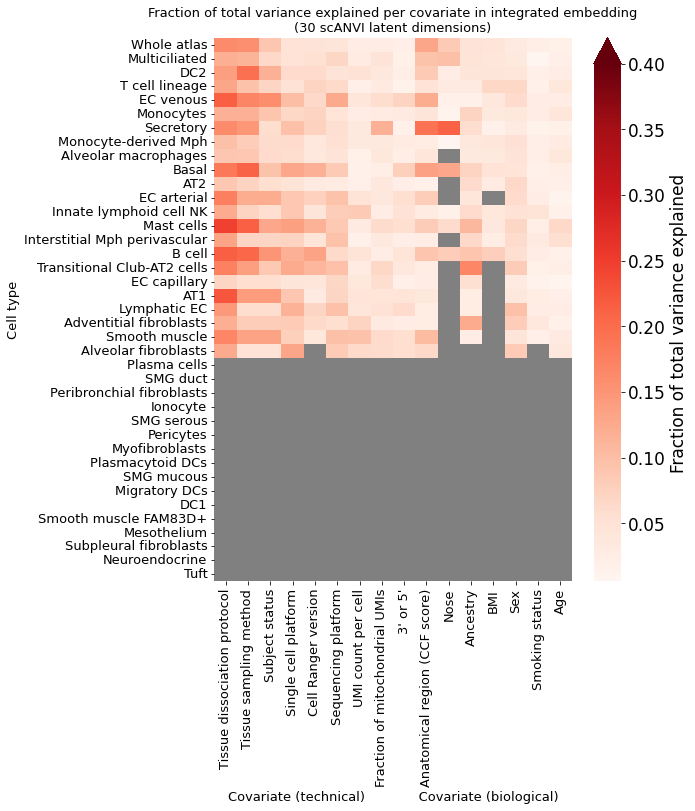

In [46]:
fz = 13  # fontsize
cmap = copy.copy(cm.get_cmap("Reds"))  # select color map
cmap.set_bad("grey")  # set masked color to grey instead of white
fig, ax = plt.subplots(figsize=(8, 10))  # figsize
vmax = 0.4
title = "Fraction of total variance"
# for file storing:
title_no_spaces = title.replace(" ", "_")
sns.heatmap(
    vars_expl_to_plot.astype(float),
    ax=ax,
    vmax=vmax,
    cbar_kws={"extend": "max"},
    mask=mask_overall.loc[vars_expl_to_plot.index, vars_expl_to_plot.columns].values,
    cmap=cmap,
)
ax.collections[0].colorbar.set_label(f"{title} explained", fontsize=fz + 4)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=fz)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=fz)
plt.title(
    f"{title} explained per covariate in integrated embedding\n(30 scANVI latent dimensions)",
    fontsize=fz,
)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=fz + 4)
plt.xlabel("Covariate (technical)             Covariate (biological)", fontsize=fz)
plt.ylabel("Cell type", fontsize=fz)
plt.show()
plt.close()
FIGURES[f"4a_{title_no_spaces}_explained_per_covariate_{int_type}_emb"] = fig

## Explore relations between variance explained and other factors (e.g. technical vs biological covariates) (Extended Data Figure 9a, b)

Optional: check relationship between number of categories in a covariate and the amount of variance it explains (per cell type). Note that there is a quite strong relation between the two.

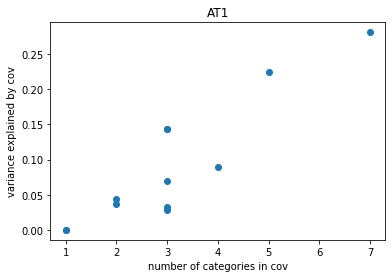

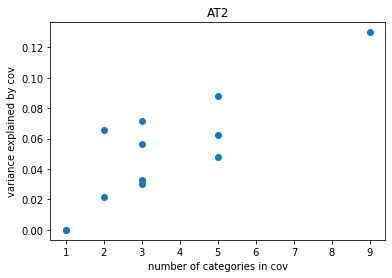

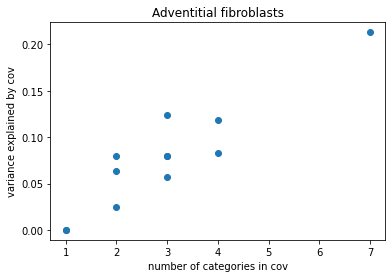

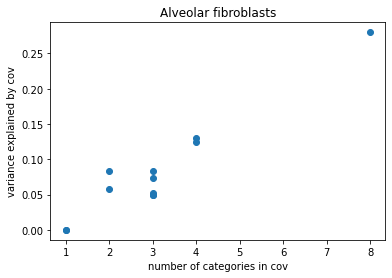

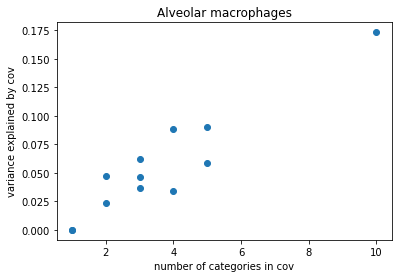

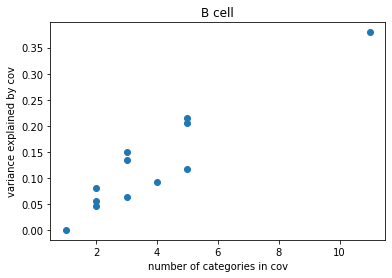

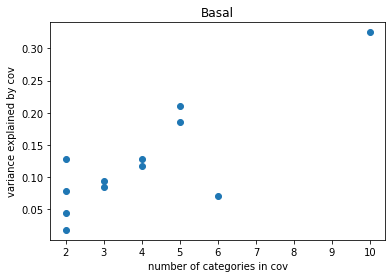

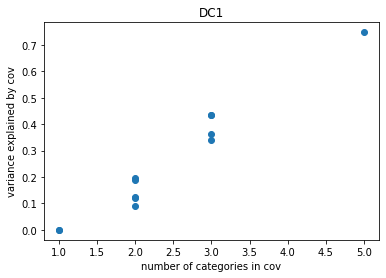

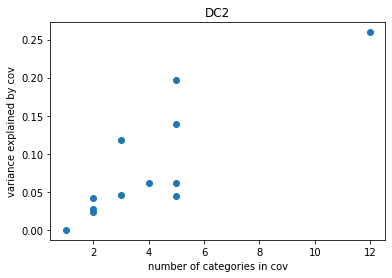

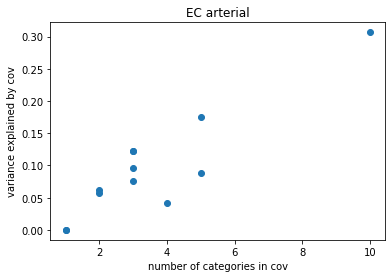

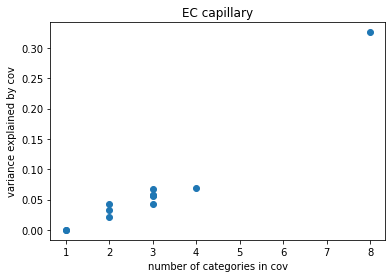

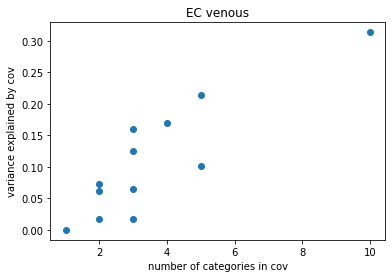

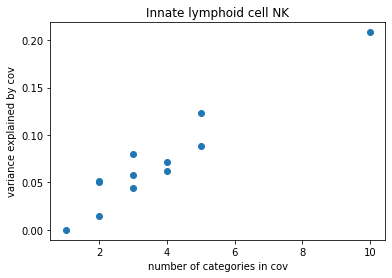

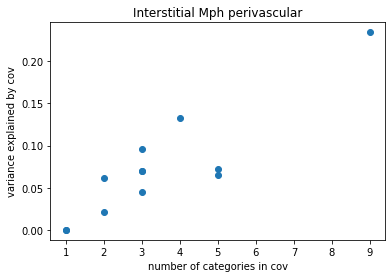

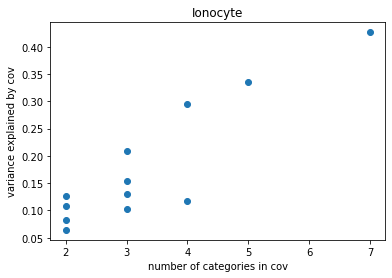

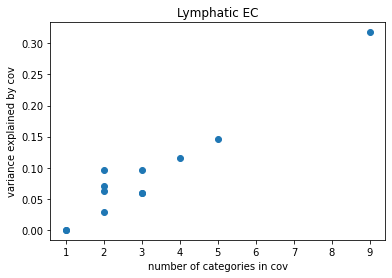

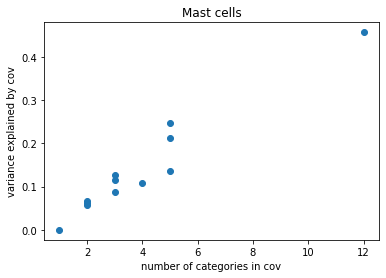

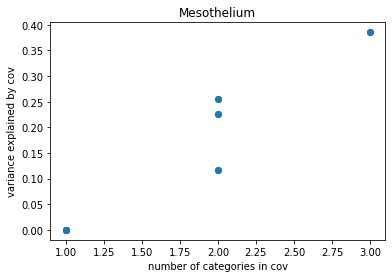

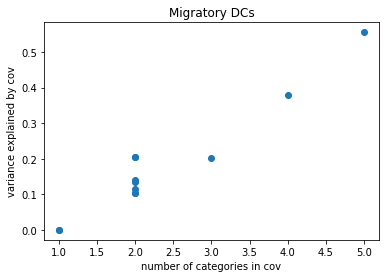

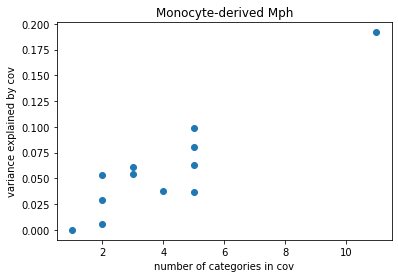

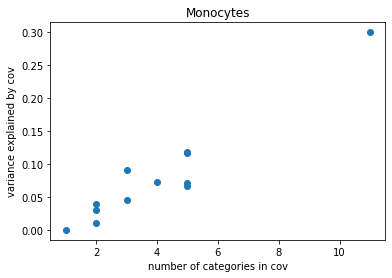

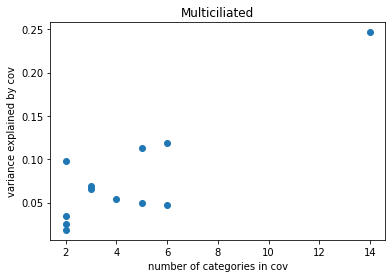

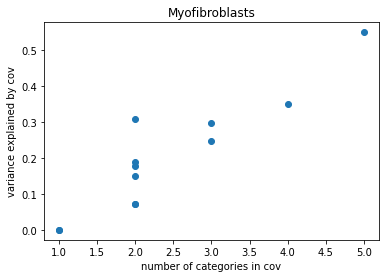

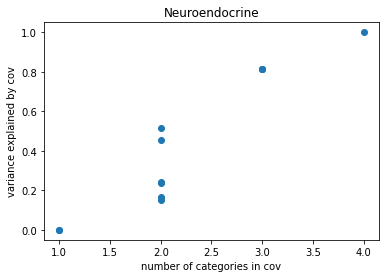

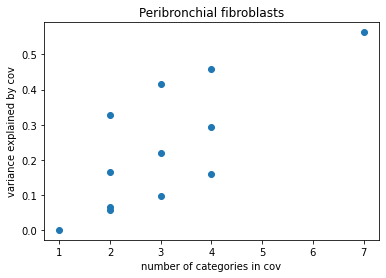

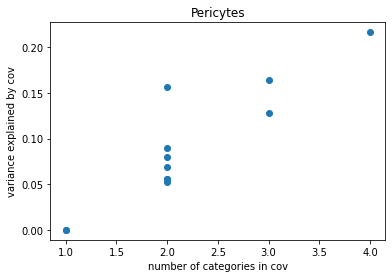

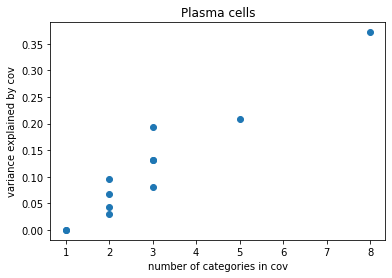

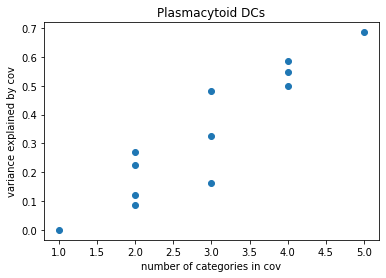

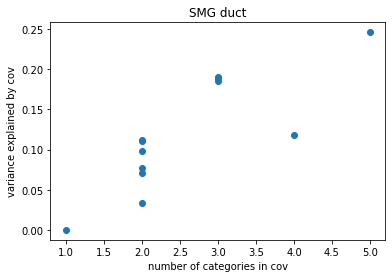

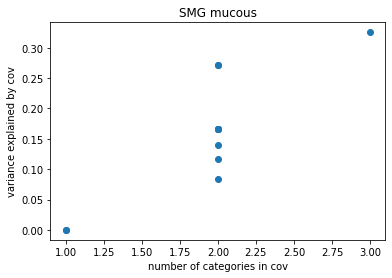

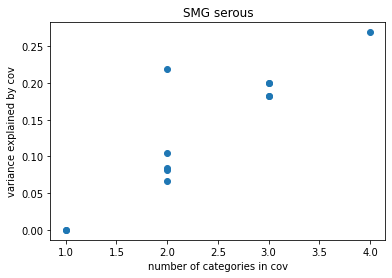

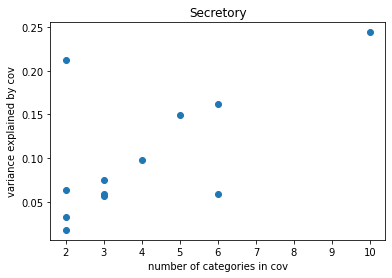

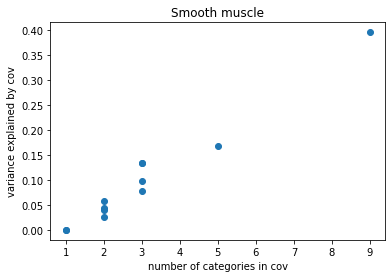

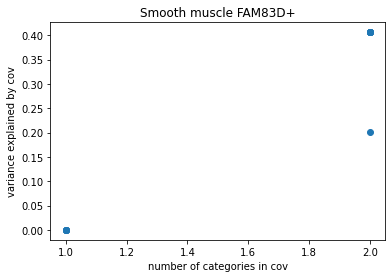

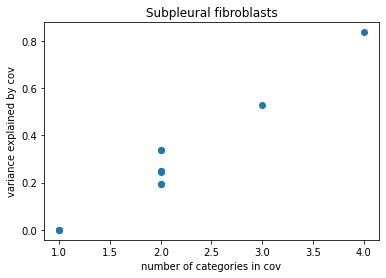

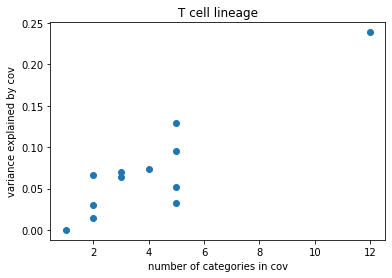

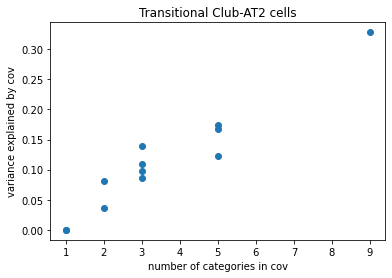

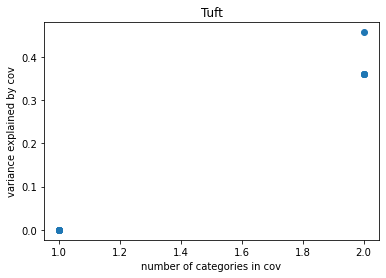

In [47]:
for subset in subsets:
    if subset not in cts_to_skip:
        cols = [col for col in cat_covs if col not in ["subject_ID", "manual_ann"]]
        if subset not in "whole_atlas":
            plt.scatter(n_cats_per_cov.loc[subset, cols], vars_expl.loc[subset, cols])
            plt.xlabel("number of categories in cov")
            plt.ylabel("variance explained by cov")
            plt.title(subset)
            plt.show()

Calculate mean variance explained across covariates (technical, bio or both), per cell type:

In [48]:
mean_var_expl = pd.DataFrame(index=vars_expl_to_plot.index)

In [49]:
mean_var_expl["bio"] = vars_expl_to_plot.loc[
    :,
    [
        col
        for col in vars_expl_to_plot.columns
        if col in [col_remapper[cov] for cov in bio_covariates]
    ],
].mean(axis=1)

In [50]:
mean_var_expl["tech"] = vars_expl_to_plot.loc[
    :,
    [
        col
        for col in vars_expl_to_plot.columns
        if col in [col_remapper[cov] for cov in technical_covariates]
    ],
].mean(axis=1)
mean_var_expl["overall"] = vars_expl_to_plot.mean(axis=1)
# mean_var_expl["ct"] = vars_expl_to_plot.index

SUPPLEMENTARY FIGURE

Plot relationship between number of samples with celltype, and the mean variance explained by covariates in that celltype.

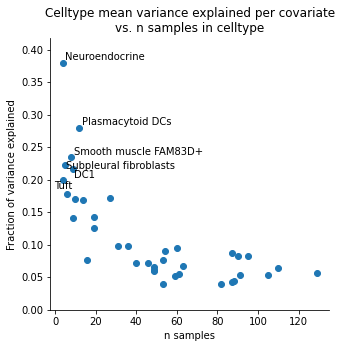

In [51]:
x = n_cats_per_cov.loc[cts_ordered, "sample"]
y = mean_var_expl.loc[cts_ordered, "overall"]
fz = 10
with plt.rc_context(
    {
        "figure.figsize": (5, 5),
        "xtick.labelsize": fz,
        "ytick.labelsize": fz,
        "axes.labelsize": fz,
        "font.size": fz,
        "axes.spines.right": False,
        "axes.spines.top": False,
    }
):
    fig, ax = plt.subplots()
    ax.scatter(x, y)
    ax.set_ylim((0, 1.1 * np.max(y)))
    texts = [
        plt.text(x[ct], y[ct.replace("_", " ")], ct)
        for ct in x.index
        if x[ct] < 20 and y[ct.replace("_", " ")] > 0.18
    ]
    adjust_text(texts)
    ax.set_xlabel("n samples")
    ax.set_ylabel("Fraction of variance explained")

    ax.set_title(
        "Celltype mean variance explained per covariate\nvs. n samples in celltype"
    )
    plt.show()
    FIGURES["ED9a_mean_var_expl_per_cov_ct_vs_nsample"] = fig

Plot ratio of bio_cov/tech_cov var explained:

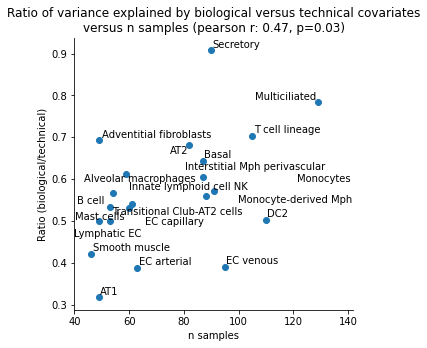

In [52]:
with plt.rc_context(
    {
        "figure.figsize": (5, 5),
        "xtick.labelsize": fz,
        "ytick.labelsize": fz,
        "axes.labelsize": fz,
        "font.size": fz,
        "axes.spines.right": False,
        "axes.spines.top": False,
    }
):
    fig, ax = plt.subplots()
    x = n_cats_per_cov.loc[cts_ordered, "sample"]
    y = mean_var_expl.loc[cts_ordered, "bio"] / mean_var_expl.loc[cts_ordered, "tech"]
    # remove celltypes with n_samples < 40
    filt = x > 40
    x = x[filt]
    y = y[filt]
    # calculate pearson correlation
    r, p = pearsonr(x, y)
    r = round(r, 2)
    p = round(p, 2)
    ax.scatter(x, y)
    ax.set_xlim((40, 1.1 * np.max(x)))
    texts = [
        plt.text(x[ct], y[ct.replace("_", " ")], ct)
        for ct in x.index
        if x[ct] > 40 and y[ct.replace("_", " ")] > 0.1
    ]
    adjust_text(texts)
    ax.set_xlabel("n samples")
    ax.set_ylabel("Ratio (biological/technical)")

    ax.set_title(
        f"Ratio of variance explained by biological versus technical covariates\nversus n samples (pearson r: {r}, p={p})"
    )
    plt.show()
    FIGURES["ED9b_bio_over_tech_var_explained_vs_nsamples"] = fig

Now check if there's a relation (and how strong) between the diversity in sampling methods for a cell type, and the fraction of variance explained by sampling method for that cell type. 

We will only include the cell types that passed our filtering of at minimum 40 samples, and we will not include the whole HLCA as a separate "cell type".

In [53]:
cts_to_incl = n_cats_per_cov.index[n_cats_per_cov.loc[:, "sample"] > 40]
cts_to_incl = [ct for ct in cts_to_incl if ct != "whole_atlas"]

Initiate dataframe in which to store the variance explained by sampling method, and the sampling method entropy per cell type.

In [54]:
sampl_m_entropy_vs_var_expl = pd.DataFrame(
    index=cts_ordered,
    columns=["sampl_m_var_expl", "sampl_m_entr"],
)
sampl_m_entropy_vs_var_expl.sampl_m_var_expl = vars_expl_to_plot.loc[
    cts_ordered, "Tissue sampling method"
]

In [55]:
for ct in cts_ordered:
    # take only the samples that passed filtering in beginning of notebook
    # into account:
    sampl_ms = sample_df.loc[samples_included[ct].sample_type, "sample_type"]
    sampl_m_frequency = (
        sample_df.loc[samples_included[ct].sample_type, :]
        .groupby("sample_type")
        .agg({"sample_type": "count"})
    )
    entr_sample_m = entropy(sampl_m_frequency)
    sampl_m_entropy_vs_var_expl.loc[ct, "sampl_m_entr"] = entr_sample_m[0]

Now plot relation between entropy and var explained for sampling method:

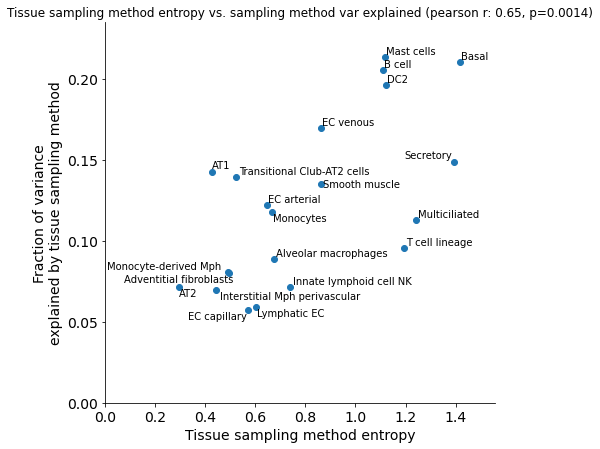

In [56]:
fz = 14
with plt.rc_context(
    {
        "figure.figsize": (7, 7),
        "xtick.labelsize": fz,
        "ytick.labelsize": fz,
        "axes.labelsize": fz,
        "font.size": fz - 4,
        "axes.spines.right": False,
        "axes.spines.top": False,
    }
):
    fig, ax = plt.subplots()
    x = sampl_m_entropy_vs_var_expl.sampl_m_entr
    y = sampl_m_entropy_vs_var_expl.sampl_m_var_expl
    n_samples_per_ct = n_cats_per_cov.loc[cts_ordered, "sample"]
    # remove celltypes with n_samples < 40
    filt = n_samples_per_ct > 40
    x = x[filt]
    y = y[filt]
    # calculate pearson correlation
    r, p = pearsonr(x, y)
    r = round(r, 2)
    p = round(p, 4)
    ax.scatter(x, y)
    ax.set_xlim((0, 1.1 * np.max(x)))
    ax.set_ylim((0, 1.1 * np.max(y)))
    texts = [
        plt.text(x[ct], y[ct.replace("_", " ")], ct)
        for ct in x.index
        if x[ct] > 0 and y[ct.replace("_", " ")] > 0  # 0.06
    ]
    adjust_text(texts)
    ax.set_xlabel("Tissue sampling method entropy")
    ax.set_ylabel("Fraction of variance\nexplained by tissue sampling method")

    ax.set_title(
        f"Tissue sampling method entropy vs. sampling method var explained (pearson r: {r}, p={p})"
    )
    plt.show()
    FIGURES["ED7d_sampl_meth_entr_vs_varexpl"] = fig

## Correlation between covariates (at sample level): Extended Data Figure 9c

To check to what extend the analysis above is influenced by confounding between covariates, we now check correlation/mutual information between covariate pairs, for every cell type:

Calculate per sample statistics. Generate a dictionary that specifies for every covariate how to aggregate across cells for each sample, cell type (as done earlier in notebook).

In [57]:
# filter aggregation dictionary that we'll use for summarizing stats per sample
# based on covariates included in main figure:
agg_dict_filt = dict()
for cov, agg_type in agg_dict.items():
    if cov in col_remapper.keys():
        if col_remapper[cov] in vars_expl_to_plot.columns:
            agg_dict_filt[cov] = agg_type

Check if results directory for correlation between covariates exists. If not, create it:

In [58]:
dir_results_cov_corrs = os.path.join(dir_results, "corr_between_covs")
if not os.path.exists(dir_results_cov_corrs):
    print("creating directory", dir_results_cov_corrs)
    os.makedirs(dir_results_cov_corrs)

Loop through cell types (plus whole atlas), and calculate for every covariate pair how strongly they're correlated. We quantify "correlation" using linear-regression-based fraction of variance explained for continuous covariates, binary (boolean) covariates, or a covariate pair with only one covariate that has multiple categories, which can then be turned into a dummied matrix. For pairs of two covariates that are both multi-category, we use normalized mutual information as we cannot do a linear regression on these. Two outputs are generated and stored:
1. The type of "correlation" for every covariate pair, for every cell type (i.e. linear regression, NMI).<br>
2. The quantified dependence (fraction of variance explained through linear regression, or NMI)

Note that running the cell below can take a while

In [59]:
# inititate empty dicts in which to store the final results per cell type
cov_corr_types_ct = dict()
cov_corrs_ct = dict()
# now loop through cell types:
for subset in ["whole_atlas"] + sorted(adata.obs.manual_ann_grouped.unique()):
    if subset not in cts_to_skip:
        subset_no_spaces = subset.replace(" ", "_")  # for file names etc.
        # if file doesn't exist yet:
        if not os.path.isfile(
            os.path.join(
                dir_results_cov_corrs,
                f"{subset_no_spaces}_corrs_between_covariates_types.csv",
            )
        ):
            print(f"Working on {subset}...")
            # select the correct cells:
            if subset == "whole_atlas":
                subobs = adata.obs.copy()
                verbose = True
            elif subset not in adata.obs.manual_ann_grouped.unique():
                raise ValueError(
                    "subset should be set either to 'whole_atlas' or to a category in your manual_ann_grouped obs variable!"
                )
            else:
                subobs = adata.obs.loc[adata.obs.manual_ann_grouped == subset, :].copy()
                verbose = False
            # Store list with covariates to plot:
            covariates_to_plot = list(agg_dict_filt.keys())
            # iniate empty dataframes to store correlations and correlation types
            cov_corrs = pd.DataFrame(
                index=covariates_to_plot, columns=covariates_to_plot
            )
            cov_corr_types = pd.DataFrame(
                index=covariates_to_plot, columns=covariates_to_plot
            )
            # loop through covariates, and second loop through remaining covariates
            # (i.e. unique covariate pairs)
            cov1_count = 0
            for cov1_n, cov1 in enumerate(covariates_to_plot):
                for cov2 in covariates_to_plot[cov1_n:]:
                    # keep only data from the samples that were included in the
                    # analysis
                    samples_to_keep = [
                        s
                        for s, cov1_incl, cov2_incl in zip(
                            samples_included[subset].index,
                            samples_included[subset][cov1],
                            samples_included[subset][cov2],
                        )
                        if cov1_incl and cov2_incl
                    ]
                    subobs_filt = subobs.loc[
                        subobs["sample"].isin(samples_to_keep), :
                    ].copy()
                    # recategorize sample so that aggregation only happens for samples included:
                    subobs_filt["sample"] = subobs_filt[
                        "sample"
                    ].cat.remove_unused_categories()
                    # collapse to sample info:
                    subobs_sample_collapsed = subobs_filt.groupby("sample").agg(
                        agg_dict
                    )
                    # now calculate correlation/mutual information
                    subobs_sample_collapsed = subobs_filt
                    (
                        cov_corr_types.loc[cov1, cov2],
                        cov_corrs.loc[cov1, cov2],
                    ) = analysis.get_correlation_or_mi(
                        cov1, cov2, subobs_sample_collapsed, verbose=True
                    )
                cov1_count += 1
            # and store results
            cov_corr_types_ct[subset] = cov_corr_types
            cov_corr_types.to_csv(
                os.path.join(
                    dir_results_cov_corrs,
                    f"{subset_no_spaces}_corrs_between_covariates_types.csv",
                )
            )
            cov_corrs_ct[subset] = cov_corrs
            cov_corrs.to_csv(
                os.path.join(
                    dir_results_cov_corrs,
                    f"{subset_no_spaces}_corrs_between_covariates_values.csv",
                )
            )

If re-starting the notebook form here (the above calculation takes quite some time), you can load the files as follows:

In [60]:
cov_corrs_ct = dict()
for subset in ["whole_atlas"] + sorted(adata.obs.manual_ann_grouped.unique()):
    if subset not in cts_to_skip:
        subset_no_spaces = subset.replace(" ", "_")
        cov_corrs_ct[subset] = pd.read_csv(
            os.path.join(
                dir_results_cov_corrs,
                f"{subset_no_spaces}_corrs_between_covariates_values.csv",
            ),
            index_col=0,
        )

Sort cell types by n_samples for figure:

In [61]:
n_samples_per_ct = pd.Series(
    {
        subset: samples_included[subset].sum(axis=0).max()
        for subset in adata.obs.manual_ann_grouped.unique()
        if subset not in cts_to_skip
    }
).sort_values()

Plot results:

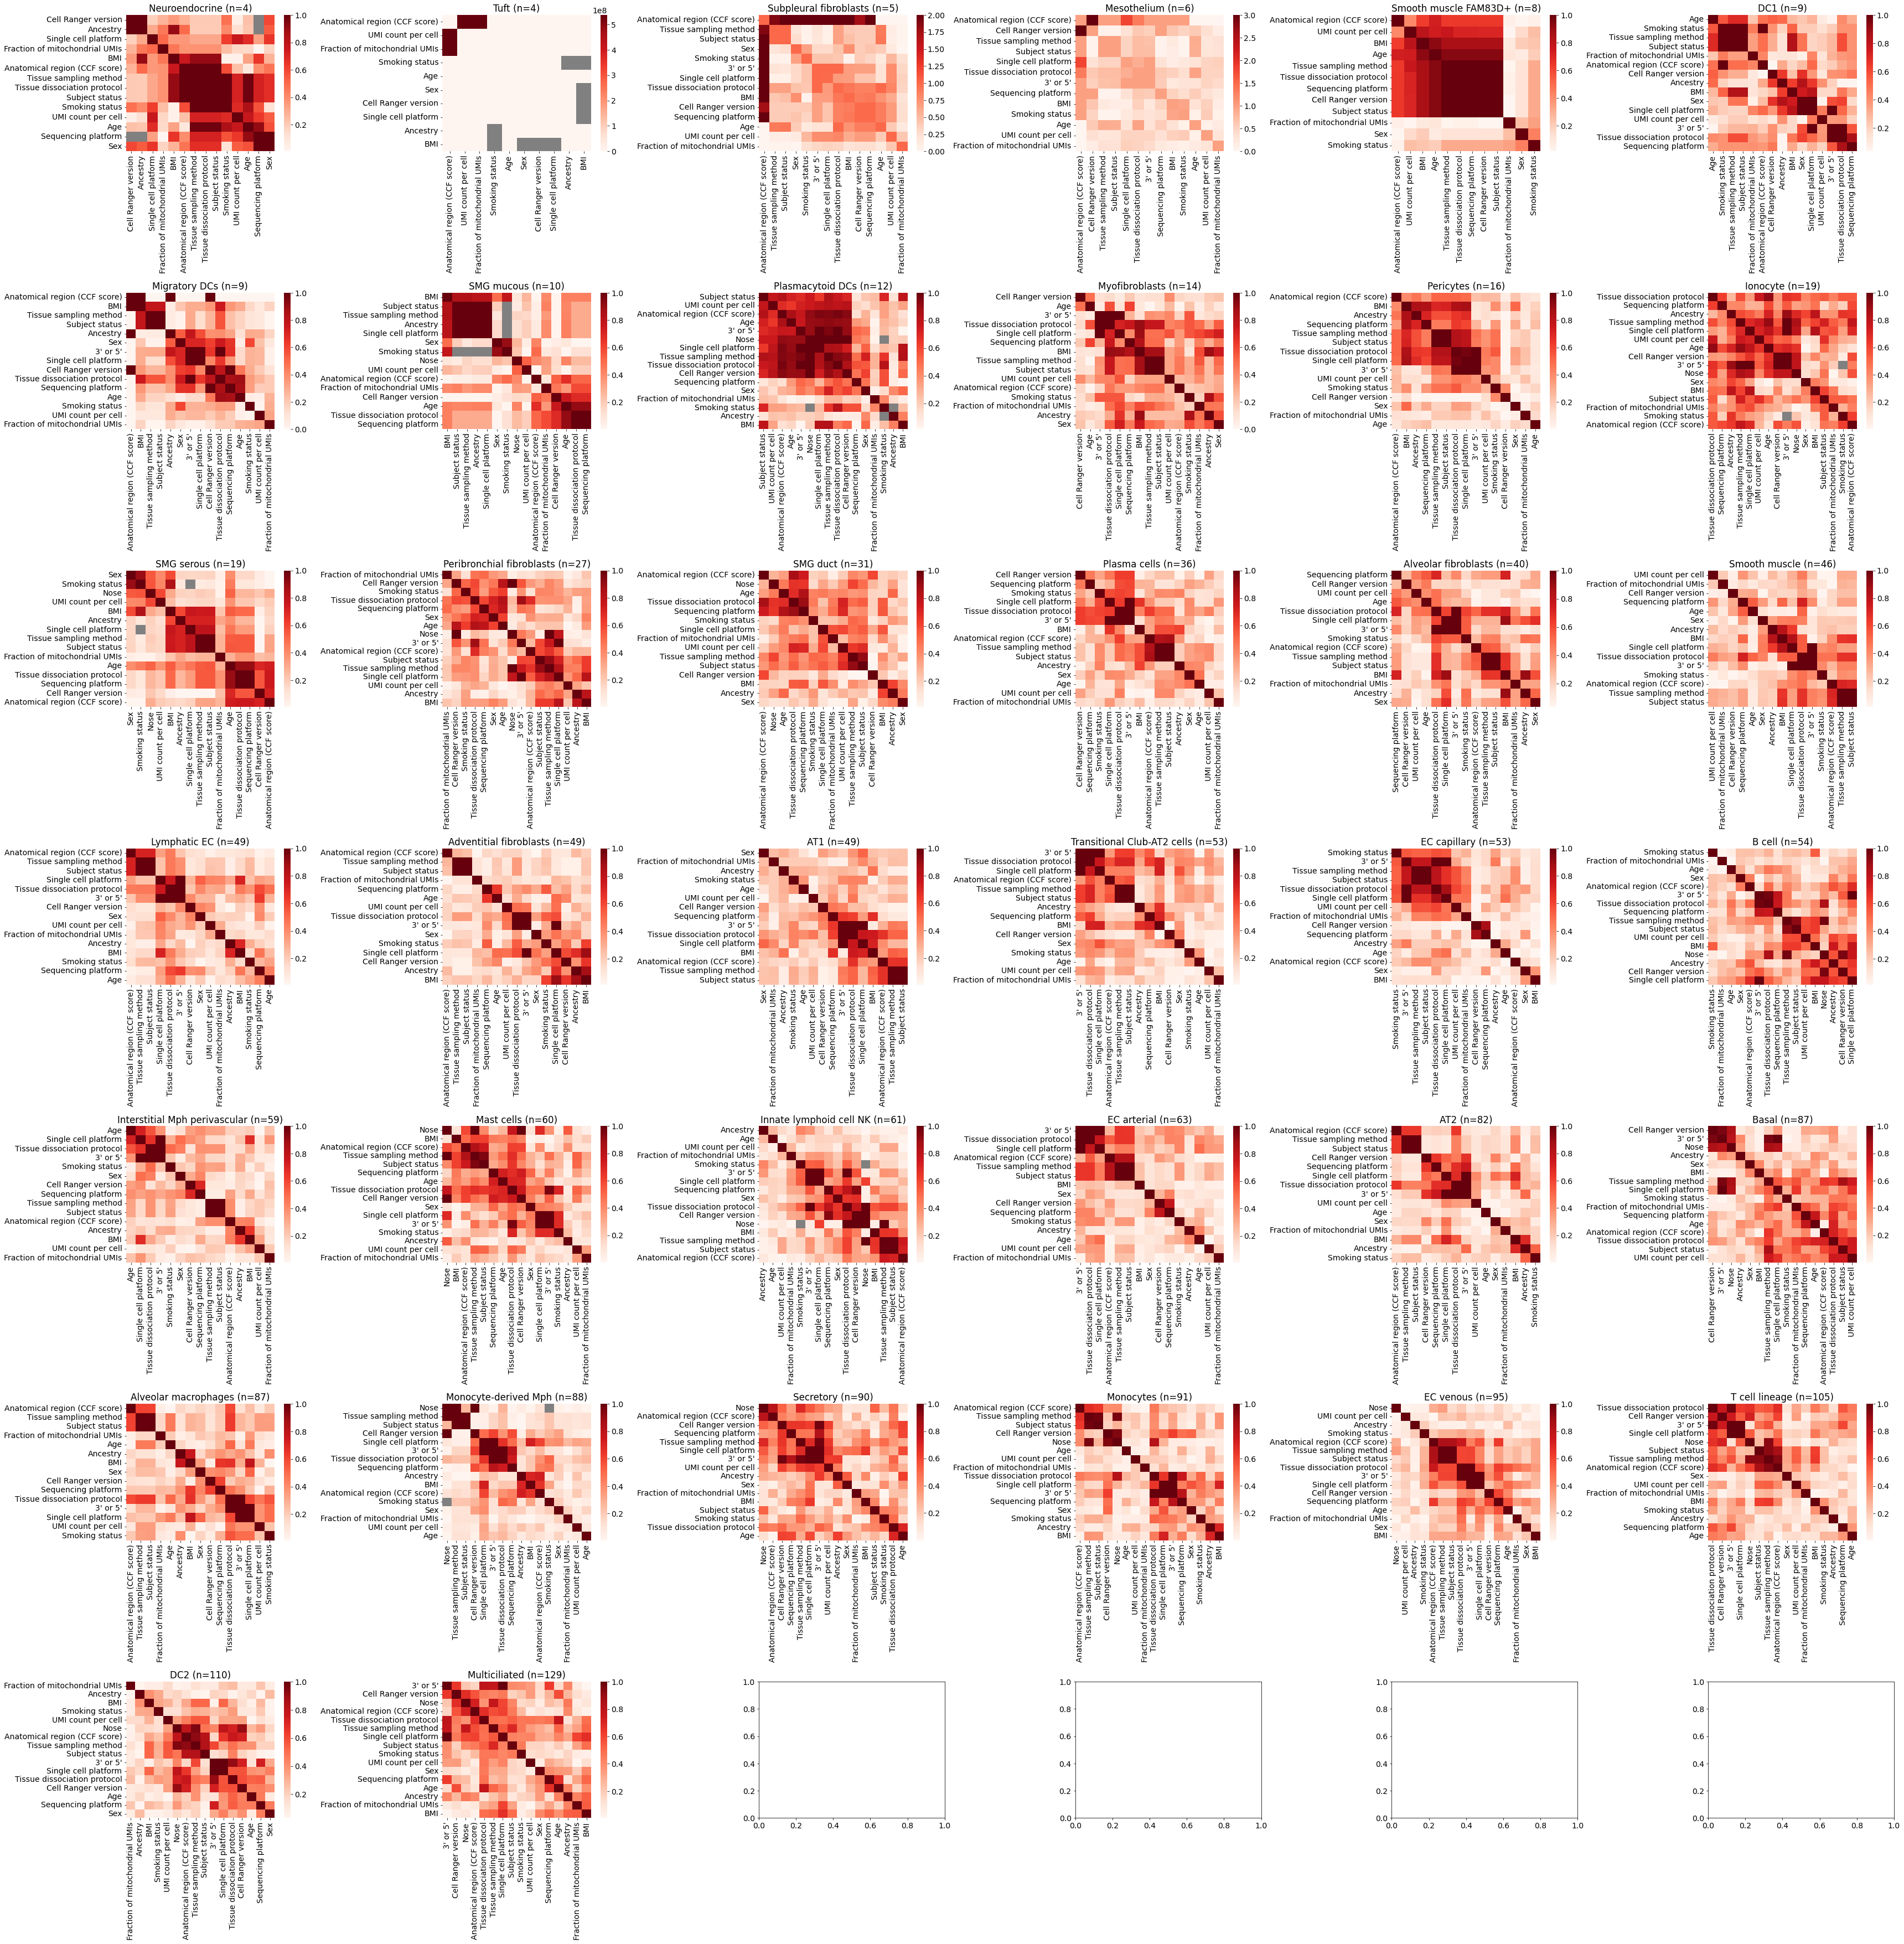

In [62]:
n_cols = 6
n_rows = 7
figwidth = 8 * n_cols
figheight = 7 * n_rows
fz = 14
with plt.rc_context(
    {
        "xtick.labelsize": fz,
        "ytick.labelsize": fz,
        "axes.labelsize": fz,
        "font.size": fz,
    }
):
    fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(figwidth, figheight))
    #     constrained_layout=True,

    # gs = GridSpec(n_rows, n_cols, figure=fig)
    fig_count = 0
    axes = dict()
    for subset in n_samples_per_ct.index:
        cov_corrs = cov_corrs_ct[subset]
        # extract max number of samples included for the cell type:
        # (max, becaue it is not the same for every covariate)
        n_samples = str(int(n_samples_per_ct[subset]))
        # fill in second half (below diagonal):
        for row_n, row in enumerate(cov_corrs.index):
            for col_n, col in enumerate(cov_corrs.columns[row_n + 1 :]):
                cov_corrs.loc[col, row] = cov_corrs.loc[row, col]
        row = int(np.floor(fig_count / n_cols))
        col = fig_count % n_cols
        # remove rows/columns with nan only
        # (i.e. variables that had 0 variance in that cell type):
        rows_to_remove = np.where(
            pd.isnull(cov_corrs).sum(axis=0) == cov_corrs.shape[0]
        )
        row_names_to_remove = cov_corrs.index[rows_to_remove]
        cov_corrs.drop(
            index=row_names_to_remove, columns=row_names_to_remove, inplace=True
        )
        # mask remaining nan values (don't think they're there)
        mask = pd.isnull(cov_corrs)
        c = sns.clustermap(data=cov_corrs.fillna(0), mask=mask)
        order = c.dendrogram_row.reordered_ind
        plt.close()
        ind = cov_corrs.index[order]
        cov_corrs = cov_corrs.loc[ind, ind]
        mask = cov_corrs.isnull()
        cov_corrs.fillna(0, inplace=True)
        # clean up column + row names:
        cov_corrs_clean = cov_corrs.rename(columns=col_remapper, index=col_remapper)
        mask_clean = mask.rename(columns=col_remapper, index=col_remapper)
        sns.heatmap(data=cov_corrs_clean, ax=ax[row, col], mask=mask_clean, cmap=cmap)
        ax[row, col].set_title(f"{subset} (n={n_samples})")
        fig_count += 1
        plt.tight_layout()
    plt.show()
    plt.close()
    FIGURES["ED9c_correlations_between_covariates_sample_level"] = fig

### Store figures:

In [63]:
for figname, fig in FIGURES.items():
    print("saving", figname)
    fig.savefig(
        os.path.join(dir_figures, f"{figname}.png"),
        bbox_inches="tight",
        dpi=140,
        transparent=True,
    )
    plt.close()

saving 4a_Fraction_of_total_variance_explained_per_covariate_integrated_emb
saving ED7a_mean_var_expl_per_cov_ct_vs_nsample
saving ED7b_bio_over_tech_var_explained_vs_nsamples
saving ED7d_sampl_meth_entr_vs_varexpl
saving ED7c_correlations_between_covariates_sample_level
